<a href="https://colab.research.google.com/github/jgbrasier/protein-classification/blob/main/ProtClass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep sequence models for protein classification

In [4]:
import io
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import torch as th
import torch.nn as nn

## Downloading data
download and save to local drive: https://www.kaggle.com/shahir/protein-data-set

### Uploading data to Colab

Click on "chose files" upload both:
 - pdb_data_seq.csv
 - pdb_data_no_dups.csv

In [5]:
from google.colab import files
# upload 'pdb_data_seq.csv'
uploaded = files.upload()

Saving pdb_data_seq.csv to pdb_data_seq.csv


In [7]:
# upload 'pdb_data_np_dupes.csv'
uploaded2 = files.upload()

Saving pdb_data_no_dups.csv to pdb_data_no_dups.csv


In [8]:
# convert data to pandas dataframe
seq = pd.read_csv(io.BytesIO(uploaded['pdb_data_seq.csv']))
nodups = pd.read_csv(io.BytesIO(uploaded2['pdb_data_no_dups.csv']))

## Data cleaning and preparation

In [9]:
# merge both data frames on structure id, remove duplicates
df = nodups.merge(seq, how='inner', on='structureId').drop_duplicates(['structureId'])
# remove NaN values
df = df.dropna()
# keep only proteins and reset indexes
df = df[df['macromoleculeType_x'] == 'Protein'].reset_index()
# keep structureId, classification, residueCount_x, sequence
df = df[['structureId', 'classification', 'residueCount_x', 'sequence']]
df.columns = ['structureId', 'classification', 'residueCount', 'sequence']
print("Total number of unique proteins:", len(df))

Total number of unique proteins: 60757


In [10]:
df.head()

,structureId,classification,residueCount,sequence
0,1914,ALU DOMAIN,232,MASMTGGQQMGRIPGNSPRMVLLESEQFLTELTRLFQKCRSSGSVF...
1,1A04,SIGNAL TRANSDUCTION PROTEIN,430,SNQEPATILLIDDHPMLRTGVKQLISMAPDITVVGEASNGEQGIEL...
2,1A0R,COMPLEX (TRANSDUCER/TRANSDUCTION),650,XSELDQLRQEAEQLKNQIRDARKACADATLSQITNNIDPVGRIQMR...
3,1A2B,ONCOGENE PROTEIN,182,SMAAIRKKLVIVGDVACGKTCLLIVFSKDQFPEVYVPTVFENYVAD...
4,1A2X,COMPLEX (SKELETAL MUSCLE/MUSCLE PROTEIN),206,TDQQAEARSYLSEEMIAEFKAAFDMFDADGGGDISVKELGTVMRML...


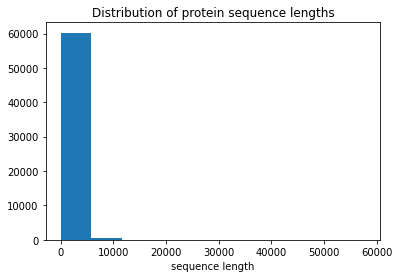

In [11]:
plt.hist(df['residueCount'])
plt.xlabel('sequence length')
plt.title('Distribution of protein sequence lengths')
plt.show()

In [12]:
# remove proteins with lengths > 2000 to save compute time on LSTM models
max_len = 2000
df = df[df['residueCount'] < max_len]
print("Total number of unique proteins:", len(df))
print("Total number of unique classification labels:", len(df.classification.unique()))

Total number of unique proteins: 57359
Total number of unique classification labels: 2052


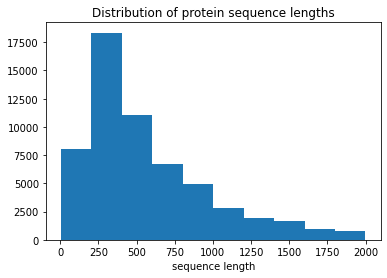

In [13]:
plt.hist(df['residueCount'])
plt.xlabel('sequence length')
plt.title('Distribution of protein sequence lengths')
plt.show()

In [19]:
# keep only 15 most important classes by instance count
N_class = 15
count = Counter(df.classification)
sort = count.most_common()[:N_class]
classes = np.array(sort)[:, 0]
sequences = df.sequence.values
df = df[[c in classes for c in df.classification]]
print("Total number of unique proteins:", len(df))

Total number of unique proteins: 39070


In [15]:
df.classification.value_counts()

HYDROLASE                            9704
TRANSFERASE                          7277
OXIDOREDUCTASE                       5544
IMMUNE SYSTEM                        2333
LYASE                                2177
TRANSCRIPTION                        1660
TRANSPORT PROTEIN                    1608
HYDROLASE/HYDROLASE INHIBITOR        1457
SIGNALING PROTEIN                    1286
TRANSFERASE/TRANSFERASE INHIBITOR    1242
ISOMERASE                            1205
LIGASE                               1000
VIRAL PROTEIN                         944
PROTEIN BINDING                       861
MEMBRANE PROTEIN                      772
Name: classification, dtype: int64

In [20]:
# one hot encode classes
lb = LabelBinarizer()
Y = lb.fit_transform(df.classification)

# tokenize our sequences
# create fit
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(sequences)
#represent input data as word rank number sequences
X = tokenizer.texts_to_sequences(sequences)
X = sequence.pad_sequences(X, maxlen=max_len)
print('X shape:', X.shape, 'Y shape:', Y.shape)

X shape: (39070, 2000) Y shape: (39070, 15)


In [22]:
# 80/20 train test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2)
X_train = th.from_numpy(X_train)
X_test = th.from_numpy(X_test)
y_train = th.from_numpy(y_train)
y_test = th.from_numpy(y_test)

GPU compute setup

In [30]:
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
# pass train/test variables to torch detected device 
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)
# sanity check 
X_train.is_cuda


True

## Model